In [2]:
#import statements
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

In [3]:
df = pd.read_csv('data/INTC_forecast.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,20.79000,21.03000,20.73000,20.88000,13.66044,47800900
1,2010-01-05,20.94000,20.99000,20.60000,20.87000,13.65391,52357700
2,2010-01-06,20.81000,20.93000,20.67000,20.80000,13.60811,40037400
3,2010-01-07,20.73000,20.76000,20.34000,20.60000,13.47726,54041500
4,2010-01-08,20.54000,20.89000,20.40000,20.83000,13.62774,48234700


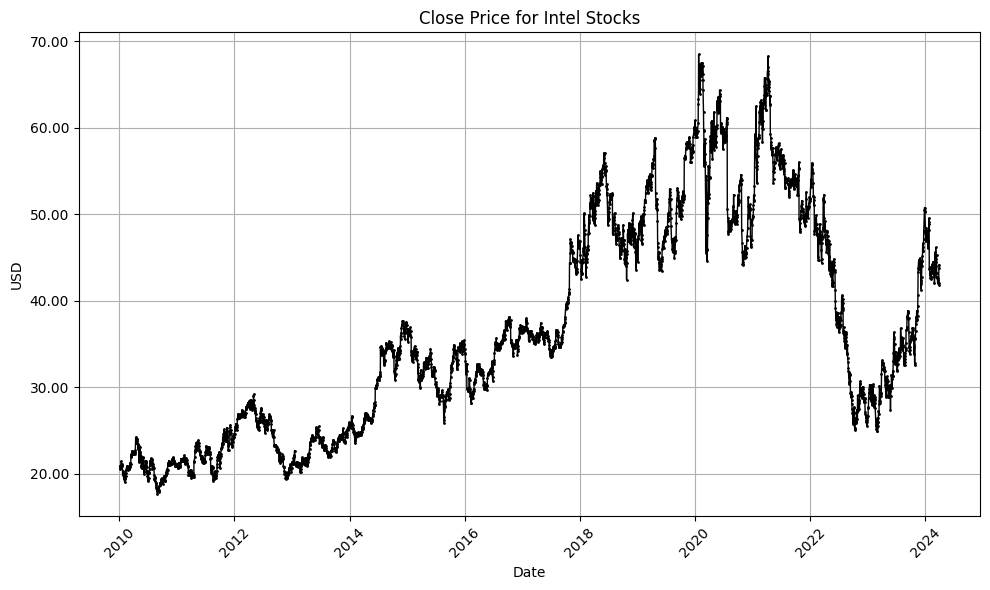

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], marker='o', linestyle='-', color='black',markersize = 1,linewidth=1)
plt.title('Close Price for Intel Stocks')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The time-series plot of Intel stock price is not statoinary.There was an upward trend until 20201, a fall off between then and 20203 and a rising trend from then till now (2024)

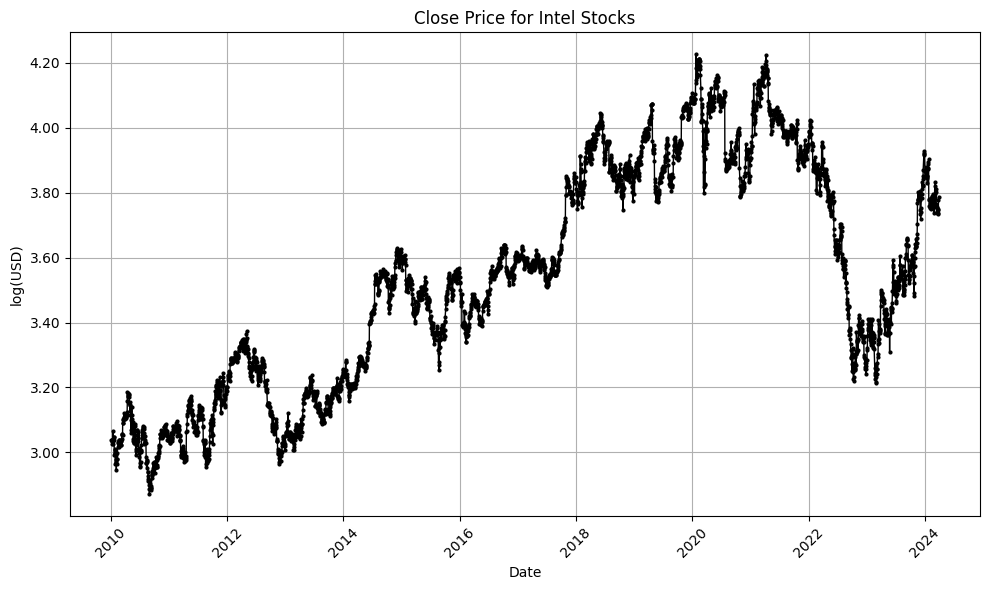

In [5]:
df['log_Close'] = np.log(df['Close'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['log_Close'], marker='o', linestyle='-', color='black',markersize = 2,linewidth=1)
plt.title('Close Price for Intel Stocks')
plt.xlabel('Date')
plt.ylabel('log(USD)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The logged close price still does not exhibit stationary behavior

In [6]:
adf_result = adfuller(df['log_Close'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                  -1.85344
p-value                          0.35427
#Lags Used                      18.00000
Number of Observations Used   3564.00000
Critical Value (1%)             -3.43219
Critical Value (5%)             -2.86235
Critical Value (10%)            -2.56720
dtype: float64

The ADF test confirms the non-stationarity with a high p-value: 0.35. We must then difference the close price to achieve stationarity

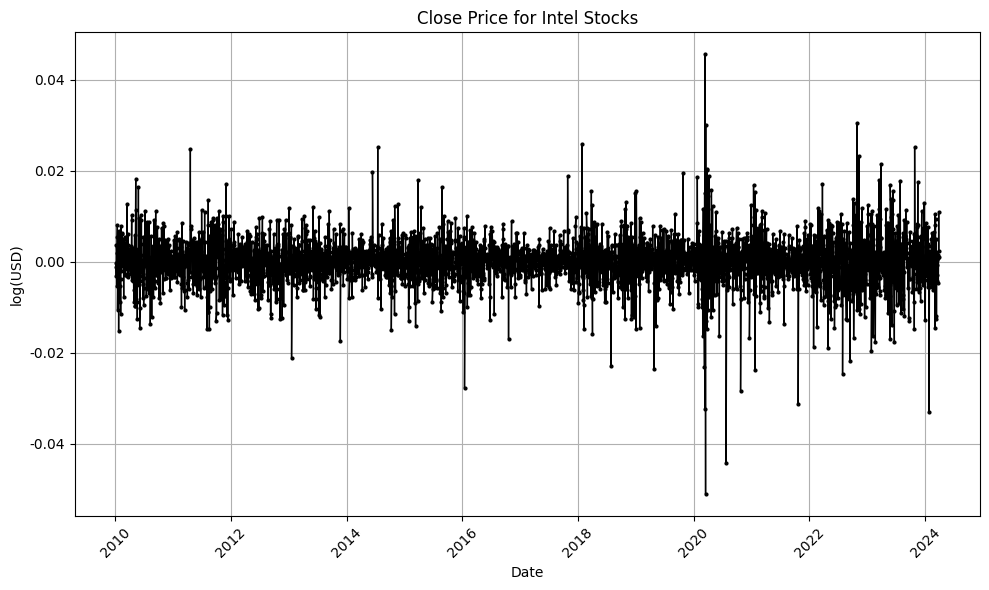

In [7]:
df['log_Close_diff'] = np.log(df['log_Close']).diff()

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['log_Close_diff'], marker='o', linestyle='-', color='black',markersize = 2,linewidth=1)
plt.title('Close Price for Intel Stocks')
plt.xlabel('Date')
plt.ylabel('log(USD)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This is a stationary timeseries, we can now move forward with fitting our ARIMA model

In [8]:
adf_result = adfuller(df['log_Close_diff'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                 -14.38080
p-value                          0.00000
#Lags Used                      17.00000
Number of Observations Used   3564.00000
Critical Value (1%)             -3.43219
Critical Value (5%)             -2.86235
Critical Value (10%)            -2.56720
dtype: float64

The p-value of our ADF test being 0 confirms that our time series is indeed stationary

In [9]:
from pmdarima import auto_arima
import pandas as pd

# Note: We drop the first NaN value that results from differencing
series = df['Close'].dropna()
series.index = pd.to_datetime(df['Date'])  # Assuming 'series.index' contains date strings


# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        seasonal=False,
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8751.625, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8676.763, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8685.951, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8749.850, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8668.145, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8664.268, Time=0.29 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=8661.572, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=8663.223, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=8661.014, Time=0.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8644.552, Time=0.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8667.865, Time=0.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8619.009, Time=1.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8663.208, Time=0.67 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=8642.012, Time=1.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

In [10]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (3, 1, 2)
Seasonal order: (0, 0, 0, 0)


In [11]:
# Split the dataset into training and test sets
train_size = int(len(series) * 0.95)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in range(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

Test RMSE: 0.9918630863586461


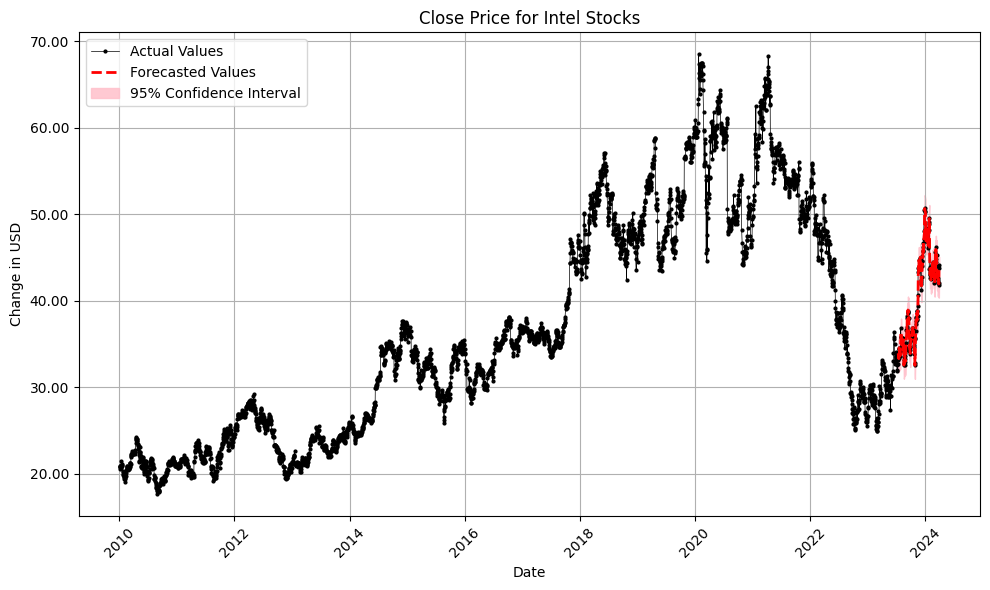

In [12]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Close Price for Intel Stocks')
plt.xlabel('Date')
plt.ylabel('Change in USD')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Based on our rolling origin forecast, our ARIMA (3, 1, 2) model performs quite well at forecasting the one-step-ahead value of Intel stocks. On average it is only 0.99 USD off from the actual value